# Topic Modelling using LDA

## 1. Install required libraries

In [51]:
!python -m spacy download en_core_web_lg
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## 2. Import Libraries

In [52]:
# General processing libraries
import os
import re
import time
import string
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import concurrent.futures

# Visualization libraries
import pyLDAvis
import seaborn as sns
import pyLDAvis.lda_model
import matplotlib.pyplot as plt

# Spacy based imports
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

# Gensim based imports
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel

# Modelling libraries
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [53]:
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
nlp = spacy.load('en_core_web_lg')

## 3. Load Dataset

In [54]:
df = pd.read_csv("/kaggle/input/thread-app-reviews/thread_review.csv",index_col = None).iloc[:,1:]
df.head()

,reviewId,content
0,2d88c80d-c3b8-44b7-81b6-b7c6c2f71b5a,Not private message
1,6ba418f6-affc-4c8a-b86c-10192399d032,"Im giving itn2 stars, simply because you canno..."
2,a1d379f3-121b-477f-ae53-2977d2585c62,"After 3 months of using Threads, I can very cl..."
3,6d09979f-1a42-49ad-a3d5-9b14dd48318e,Stop putting this app on my phone. I uninstall...
4,9d07e7d8-401e-4781-be8a-7fcde8bcec19,Azaz


## 4. Data Preprocessing

In [55]:
def filter_short_reviews(df, column_name):
    # Use str.split to count words and filter
    filtered_df = df[df[column_name].str.split().str.len() >= 3]
    return filtered_df

# Define stopwords and punctuation
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
print("Stopword samples: ",stopwords[0:30])

def remove_special_characters(text):
    # Remove URLs and links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emojis using regex
    text = re.sub(r'[^\w\s,]', '', text)  # Keeps only words, spaces, and commas
    return text

def spacy_tokenizer(sentence):
    # Check if the input is not a string (e.g., it's a float or NaN)
    if not isinstance(sentence, str):
        return ""
    
    # Remove special characters (links, URLs, emojis)
    sentence = remove_special_characters(sentence)

    # Tokenize the sentence
    mytokens = nlp(sentence)

    # Custom lemmatization approach
    lemmatized_tokens = []
    for word in mytokens:
        if word.lemma_ != "-PRON-":  # Handle pronouns differently
            lemmatized_word = word.lemma_.lower().strip()
            lemmatized_tokens.append(lemmatized_word)
        else:
            lemmatized_tokens.append(word.lower_)

    # Remove stopwords and punctuations
    filtered_tokens = [word for word in lemmatized_tokens if word not in stopwords and word not in punctuations]

    # Join the tokens back into a string
    final_tokens = " ".join(filtered_tokens)
    
    return final_tokens


df = filter_short_reviews(df, 'content')

tqdm.pandas()
df['content_processed'] = df['content'].progress_apply(spacy_tokenizer)
df = df.reset_index(drop=True)

Stopword samples:  ['on', 'former', 'most', 'no', 'out', 'always', 'along', 'three', 'namely', 'so', 'nor', 'perhaps', 'still', 'he', '‘re', 'otherwise', 'cannot', 'could', 'than', 'make', 'his', 'seems', 'yet', 'thereafter', 'whereupon', 'side', 'ours', 'unless', 'would', 'since']


100%|██████████| 45124/45124 [07:11<00:00, 104.57it/s]


## 5. Find Optimal Coherence Score

In [58]:
def get_coherence_score(model, df_columnm):
    topics = model.components_

    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df_columnm]

    # create the dictionary
    dictionary = Dictionary(texts)
    # Create a gensim dictionary from the word count matrix

    # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [59]:
# Finding optimal number of topics
coherence_scores = {}
topic_range = range(2, 10)  

# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["content_processed"])

for t in topic_range:
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=t, random_state = 1, max_iter=2, learning_method='online',verbose=False)
    data_lda = lda.fit_transform(data_vectorized)
    score = get_coherence_score(lda, df.content_processed)
    coherence_scores[t] = score

num_topics =  max(coherence_scores, key=coherence_scores.get)

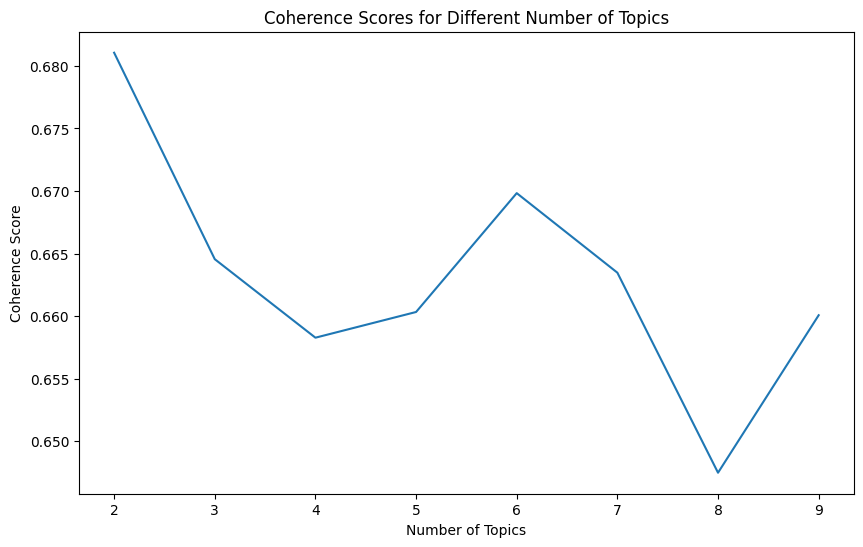

In [60]:
# Plotting the coherence scores
plt.figure(figsize=(10, 6))
sns.lineplot(x = coherence_scores.keys(), y = coherence_scores.values())
plt.title('Coherence Scores for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_range)
plt.show()

## 6. Topic Modelling Interpretation using LDA

In [61]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["content_processed"])

# Creating a model
lda = LatentDirichletAllocation(n_components=num_topics, random_state = 1, max_iter=2, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

In [62]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([(vectorizer.get_feature_names_out()[i], topic[i])
               for i in topic.argsort()[:-top_n - 1:-1]])

In [63]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('twitter', 9354.772998053735), ('app', 8128.404223080385), ('good', 6721.0029989134655), ('instagram', 4694.961945778452), ('like', 3915.834615172412), ('account', 3566.2044344398546), ('thread', 2450.6516255572365), ('bad', 1628.0794857506153), ('delete', 1451.4233570769318), ('use', 1414.2899383435922)]
Topic 1:
[('app', 9427.815085567872), ('thread', 3426.485076720269), ('post', 2693.4202712347787), ('need', 2498.6965046686), ('nice', 2328.0515890042593), ('use', 2132.2137069130995), ('love', 2044.078773612045), ('feature', 1944.4095039276622), ('work', 1912.3607900548134), ('great', 1838.2359351553573)]


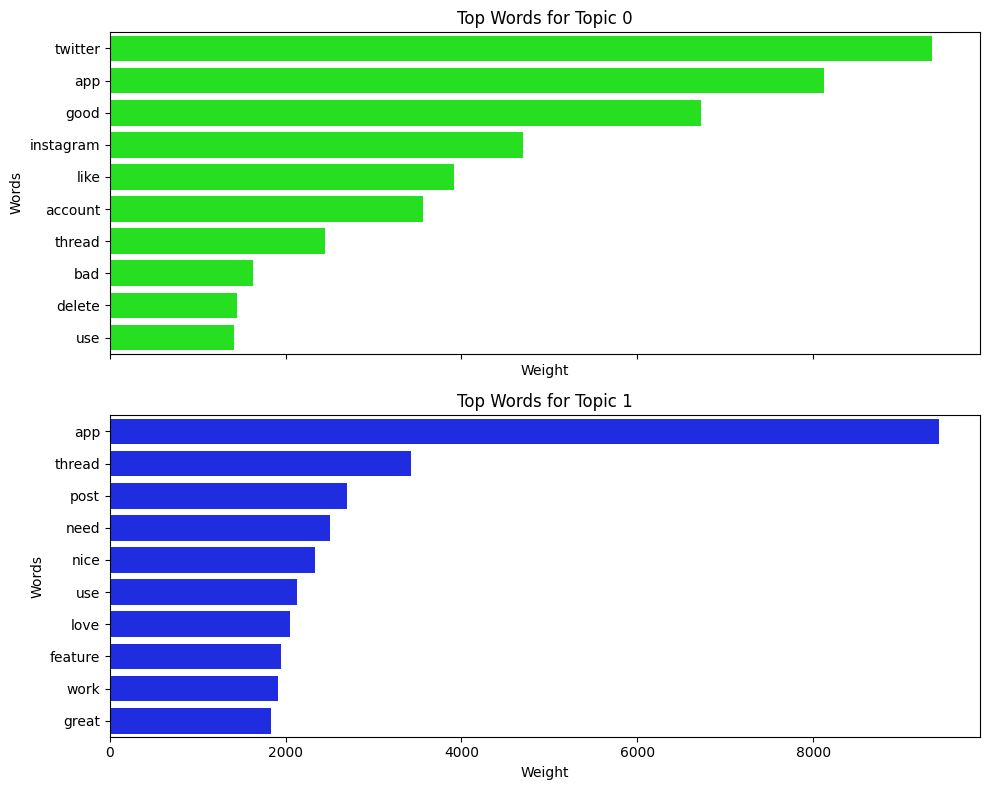

In [67]:
# Extract the top words for each topic
def get_top_words(model, vectorizer, n_top_words):
    topic_words = []
    for idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        for i in top_indices:
            topic_words.append((idx, vectorizer.get_feature_names_out()[i], topic[i]))
    return pd.DataFrame(topic_words, columns=["Topic", "Word", "Weight"])

# Get the top words
top_words_df = get_top_words(lda, vectorizer, n_top_words=10)

fig, axes = plt.subplots(num_topics, 1, figsize=(10, num_topics * 4), sharex=True)  # Create subplots

# Generate a unique color for each topic
colors = sns.color_palette("hsv", num_topics)  # Unique color palette for each topic

# Loop through each topic and create individual bar charts with unique colors
for i, ax in enumerate(axes):
    topic_data = top_words_df[top_words_df['Topic'] == i]  # Filter data for the current topic
    sns.barplot(data=topic_data, x='Weight', y='Word', ax=ax, palette=[colors[i]] * len(topic_data))
    ax.set_title(f'Top Words for Topic {i}')
    ax.set_xlabel('Weight')
    ax.set_ylabel('Words')

# Adjust layout
plt.tight_layout()
plt.show()